# Предсказание активности покупателей интернет-магазинов

## Описание проекта

Информация по трем интернет-магазинам: мультикатегорийный магазин с посещаемостью более 8 млн сессий в месяц, магазин одежды, маленький магазин подарков.
В них есть обезличенная история покупок клиентов за определенный период


## Задача

Создать решение для предсказания, совершит ли покупатель повторную покупку в течение ближайших 30 дней

## Описание данных


marketplace - мультикатегорийный магазин с посещаемостью более 8 млн сессий в месяц;  
apparel - магазин одежды, по характеристикам похожий на маркетплейс;  
gifts – магазин подарков, очень маленький;  
client_id – идентификатор клиента;  
quantity – количество товара в заказе;  
price – цена 1 единицы товара в заказе;  
message_id – идентификатор сообщения из рассылки;  
date – дата покупки;




## План

**1. Знакомство с данными**

    1.1 Импорт библиотек
    
    1.2 Загрузка данных
    
    1.3 Исследовательский анализ данных (размер, признаки, строки, типы данных, пропуски, аномалии, дубликаты, кореляция, распределение)
    
 **2. Предобработка данных**
    
    2.1 Преобразование типов данных
    
    2.2 Разбиение на выборки
    
    2.3 Нормализация значений
    
 **3. Обучение моделей**


 **4. Вывод**

 **5. Отчет**

**************

## Импорт библиотек

In [ ]:
 pip install progress

In [ ]:
pip install tqdm -U

Устанавливать библиотеки в рамках тетрадки - считается плохой практикой. Eсли заказчик или коллега захочет воспрозвести исследование он сможет установить все необходимые пакеты используя данный файл.


In [ ]:
pip install catboost

In [ ]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import StandardScaler

from catboost import CatBoostClassifier

from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import classification_report

from sklearn.utils.class_weight import compute_class_weight

from tqdm import tqdm
from datetime import timedelta

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.options.display.max_columns = 200
pd.options.display.max_rows = 200
pd.options.display.float_format = '{:.2f}'.format
pd.options.mode.chained_assignment = None

____________________________________________________________________________

## Загрузка данных

In [ ]:
df_apparel = pd.read_csv('/content/apparel-purchases.csv')

In [ ]:
df_gifts = pd.read_csv('/content/gifts-purchases.csv')

In [ ]:
df_marketplace = pd.read_csv('/content/marketplace-purchases.csv')

Получены 3 таблицы с данными

df_apparel – магазин одежды

df_gifts - маленький магазин подарков

df_marketplace - мультикатегорийный магазин с посещаемостью более 8 млн сессий в месяц

Далее таблицы будут изменяться, сохраним оригиналы для получения исходной информации без повторной загрузки таблиц.

In [ ]:
df_apparel_orig = df_apparel

In [ ]:
df_gifts_orig = df_gifts

In [ ]:
df_marketplace_orig = df_marketplace

## Исследовательский анализ данных

### Общая информация. Столбцы. Datetime

In [ ]:
df_apparel.head(2)

,client_id,quantity,price,date,message_id,recommended_by
0,1515915625468068833,1,3499.00,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
1,1515915625468068833,1,3499.00,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message


In [ ]:
df_gifts.head(2)

,client_id,quantity,price,date,message_id,recommended_by
0,1515915625803894158,1,8943.00,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
1,1515915625803894158,1,46369.00,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message


In [ ]:
df_marketplace.head(2)

,client_id,quantity,price,message_id,created_at,date
0,1515915625440944408,1,6298.00,1515915625440944408-1752-6450b79616277,2023-05-02,2023-05-02 08:49:57
1,1515915625440992498,1,7318.00,1515915625440992498-1818-646b35d089c98,2023-05-22,2023-05-22 13:52:13


In [ ]:
df_apparel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133104 entries, 0 to 133103
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   client_id       133104 non-null  int64  
 1   quantity        133104 non-null  int64  
 2   price           133104 non-null  float64
 3   date            133104 non-null  object 
 4   message_id      133104 non-null  object 
 5   recommended_by  133104 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 6.1+ MB


In [ ]:
df_gifts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811 entries, 0 to 810
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       811 non-null    int64  
 1   quantity        811 non-null    int64  
 2   price           811 non-null    float64
 3   date            811 non-null    object 
 4   message_id      811 non-null    object 
 5   recommended_by  811 non-null    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 38.1+ KB


In [ ]:
df_marketplace.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48182 entries, 0 to 48181
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   client_id   48182 non-null  int64  
 1   quantity    48182 non-null  int64  
 2   price       48182 non-null  float64
 3   message_id  48182 non-null  object 
 4   created_at  48182 non-null  object 
 5   date        48182 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 2.2+ MB


Очевидно, что таблицы можно соединить, т.к. имеются похожие признаки. Но специфика торговых объектов отличается, потому на начальном этапе выбираем тактику сравнительного анализа таблиц без объединения.

Общая информация

Таблица df_apparel

 - 133104 строк
 - 6 столбцов

Таблица df_gifts

 - 811 строк
 - 6 столбцов

1. 'client_id'  идентификатор клиента, тип данных int64, без пропусков  
2. 'quantity'  количество, тип данных int64, без пропусков  
3. 'price  цена, тип данных float64, без пропусков   
4. 'date'  дата, тип данных object, без пропусков. Содержит информацию о датах, следует перевести в тип данных datetime  
5. 'message_id'  сообщения, тип данных object, без пропусков  
6. 'recommended_by' рекомендации, тип данных object, без пропусков  

Таблица df_marketplace

 - 48182 строк
 - 6 столбцов

1. 'client_id'  идентификатор клиента, тип данных int64, без пропусков  
2. 'quantity'  количество, тип данных int64, без пропусков  
3. 'price  цена, тип данных float64, без пропусков   
4. 'message_id'  сообщения, тип данных object, без пропусков  
5. 'created_at' дата создания, тип данных object, без пропусков    
6. 'date'  дата, тип данных object, без пропусков. Содержит информацию о датах, следует перевести в тип данных datetime


Преобразуем в 3х таблицах столбец date, а в таблице df_marketplace еще  df_marketplace в тип данных datetime

In [ ]:
df_apparel['date'] = pd.to_datetime(df_apparel['date'])

In [ ]:
df_gifts['date'] = pd.to_datetime(df_gifts['date'])

В столбце date оставим только даты, уберем часы, минуты и секунды для лучшего восприятия и для совместного анализа со столбцом created_at

In [ ]:
df_marketplace[['date', 'created_at']] = df_marketplace[['date', 'created_at']].apply(pd.to_datetime)

In [ ]:
df_marketplace.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48182 entries, 0 to 48181
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   client_id   48182 non-null  int64         
 1   quantity    48182 non-null  int64         
 2   price       48182 non-null  float64       
 3   message_id  48182 non-null  object        
 4   created_at  48182 non-null  datetime64[ns]
 5   date        48182 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(1)
memory usage: 2.2+ MB


In [ ]:
df_marketplace['date'] = df_marketplace['date'].dt.date

In [ ]:
df_marketplace[['date', 'created_at']] = df_marketplace[['date', 'created_at']].apply(pd.to_datetime)

In [ ]:
df_marketplace.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48182 entries, 0 to 48181
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   client_id   48182 non-null  int64         
 1   quantity    48182 non-null  int64         
 2   price       48182 non-null  float64       
 3   message_id  48182 non-null  object        
 4   created_at  48182 non-null  datetime64[ns]
 5   date        48182 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(1)
memory usage: 2.2+ MB


In [ ]:
df_apparel.head(2)

,client_id,quantity,price,date,message_id,recommended_by
0,1515915625468068833,1,3499.00,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
1,1515915625468068833,1,3499.00,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message


In [ ]:
df_gifts.head(2)

,client_id,quantity,price,date,message_id,recommended_by
0,1515915625803894158,1,8943.00,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
1,1515915625803894158,1,46369.00,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message


In [ ]:
df_marketplace.head(2)

,client_id,quantity,price,message_id,created_at,date
0,1515915625440944408,1,6298.00,1515915625440944408-1752-6450b79616277,2023-05-02,2023-05-02
1,1515915625440992498,1,7318.00,1515915625440992498-1818-646b35d089c98,2023-05-22,2023-05-22


Признак message_id не дает информации для анализа уберем его в 3х таблицах пока.


Проверим, дает ли полезную информацию столбец recommended_by

In [ ]:
df_apparel['recommended_by'].value_counts()

bulk_message    133104
Name: recommended_by, dtype: int64

In [ ]:
df_gifts['recommended_by'].value_counts()

bulk_message    811
Name: recommended_by, dtype: int64

Столбец recommended_by так же удаляем - все значения == 'bulk_message'

In [ ]:
df_apparel = df_apparel.drop(['message_id', 'recommended_by'], axis=1)

In [ ]:
df_gifts = df_gifts.drop(['message_id', 'recommended_by'], axis=1)

In [ ]:
df_marketplace = df_marketplace.drop(['message_id'], axis=1)

В таблице df_marketplace проверим информативность столбца created_at

In [ ]:
len(df_marketplace[df_marketplace['created_at'] != df_marketplace['date']])

0

В таблице df_marketplace даты столбца created_at равны датам столбца date - удаляем

In [ ]:
df_marketplace = df_marketplace.drop(['created_at'], axis=1)

### Дубликаты

Проведем проверку на дубликаты.

In [ ]:
df_apparel.duplicated().mean()

0.4453585166486356

In [ ]:
df_gifts.duplicated().mean()

0.0690505548705302

In [ ]:
df_marketplace.duplicated().mean()

Все 3 таблицы имеют дубликаты

df_apparel – 45%

df_gifts - 7%

df_marketplace - 18%

Проверим , что это за повторы данных.

In [ ]:
df_apparel[df_apparel.duplicated()].head(50)

In [ ]:
df_gifts[df_gifts.duplicated()]

In [ ]:
df_marketplace[df_marketplace.duplicated()].head(30)

Все 3 таблицы содержат дубликаты.

Отличие по цене означает, один покупатель в один день приобретал различные товары.  

Полные дубликаты могут означать, что клиент оформил несколько заказов одного наименования, но разной расцветки или размера, поэтому дубликаты пока трогать не будем.

### Кореляция

In [482]:
display(df_apparel.corr().style.background_gradient(cmap='summer'))

,client_id,quantity,price
client_id,1.000000,0.010454,0.021993
quantity,0.010454,1.000000,-0.006959
price,0.021993,-0.006959,1.000000


In [483]:
display(df_gifts.corr().style.background_gradient(cmap='summer'))

,client_id,quantity,price
client_id,1.000000,0.000698,-0.012277
quantity,0.000698,1.000000,-0.031032
price,-0.012277,-0.031032,1.000000


In [484]:
display(df_marketplace.corr().style.background_gradient(cmap='summer'))

,client_id,quantity,price
client_id,1.000000,0.013609,0.047079
quantity,0.013609,1.000000,-0.012280
price,0.047079,-0.012280,1.000000


Проверка мультиколлинеарности сильных зависимостей признаков не выявила. У цены и количества отрицательная, хот и слабая зависимость - чем дороже, тем меньше товаров покупают.


### Распределение признаков

In [485]:
df_apparel['quantity'].value_counts()

1     132743
2        286
3         52
4          7
6          5
15         3
5          2
9          2
20         1
30         1
18         1
8          1
Name: quantity, dtype: int64

In [486]:
df_gifts['quantity'].value_counts()

1    808
2      3
Name: quantity, dtype: int64

In [487]:
df_marketplace['quantity'].value_counts()

1     47915
2       148
3        55
4        18
5        11
10       10
7         7
6         6
50        4
8         3
27        1
9         1
23        1
20        1
30        1
Name: quantity, dtype: int64

Характер распределения количества покупок 3х таблиц похож. Везьде преобладают штучные покупки, количество таких приобретений уменьшается с ростом количества единиц товара.

In [488]:
df_gifts.head()

,client_id,quantity,price,date
0,1515915625803894158,1,8943.00,2023-10-11
1,1515915625803894158,1,46369.00,2023-10-11
2,1515915625803894158,1,4666.00,2023-10-11
3,1515915625803894158,1,11963.00,2023-10-11
4,1515915625803894158,1,13107.00,2023-10-11


Посмотрим периоды времени 3 таблиц

- начало
- конец
- продолжительность

Для этогоподготовим функцию

In [489]:
def data_stat(data):
  start = df_apparel['date'].min()
  end = df_apparel['date'].max()
  period = df_apparel['date'].max() - df_apparel['date'].min()
  return start, end, period

In [490]:
data_stat(df_apparel['date'])

(Timestamp('2022-10-26 00:00:00'),
 Timestamp('2023-10-26 00:00:00'),
 Timedelta('365 days 00:00:00'))

In [491]:
data_stat(df_gifts['date'])

(Timestamp('2022-10-26 00:00:00'),
 Timestamp('2023-10-26 00:00:00'),
 Timedelta('365 days 00:00:00'))

In [492]:
data_stat(df_marketplace['date'])

(Timestamp('2022-10-26 00:00:00'),
 Timestamp('2023-10-26 00:00:00'),
 Timedelta('365 days 00:00:00'))

Все 3 таблицы имеют период времени ровно год с 26 октября 2022 по 26 октября 2023 года

Проверим таблицы на аномалии, выбросы и другие отклонения

In [493]:
df_apparel.describe()

,client_id,quantity,price
count,133104.00,133104.00,133104.00
mean,1515915625597781760.00,1.00,1110.43
std,142207574.42,0.15,1257.08
min,1515915625468060928.00,1.00,1.00
25%,1515915625490427904.00,1.00,280.00
50%,1515915625558532608.00,1.00,799.00
75%,1515915625625638912.00,1.00,1499.00
max,1515915625999034624.00,30.00,63499.00


In [494]:
df_gifts.describe()

,client_id,quantity,price
count,811.00,811.00,811.00
mean,1515915625875147776.00,1.00,14468.80
std,62554070.49,0.06,17774.34
min,1515915625803180544.00,1.00,656.00
25%,1515915625827804416.00,1.00,3878.00
50%,1515915625857734656.00,1.00,7533.00
75%,1515915625934780416.00,1.00,17938.00
max,1515915626013602560.00,2.00,173586.00


In [495]:
df_marketplace.describe()

,client_id,quantity,price
count,48182.00,48182.00,48182.00
mean,1515915625532499712.00,1.02,27918.95
std,31733874.28,0.54,44922.74
min,1515915625440099840.00,1.00,0.00
25%,1515915625517591808.00,1.00,1204.25
50%,1515915625531135232.00,1.00,9998.00
75%,1515915625557538816.00,1.00,35998.00
max,1515915625588646144.00,50.00,1299998.00


При первом приближении аномалии, выбросы и другие отклонения не выявлены. Посмотрим на данные подробнее.

Посмотрим распределения признаков 'quantity' и 'price' в зависимости от 'date'

In [496]:
def _plot_series_price(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['price']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

Text(0.5, 1.0, 'Таблица df_apparel')

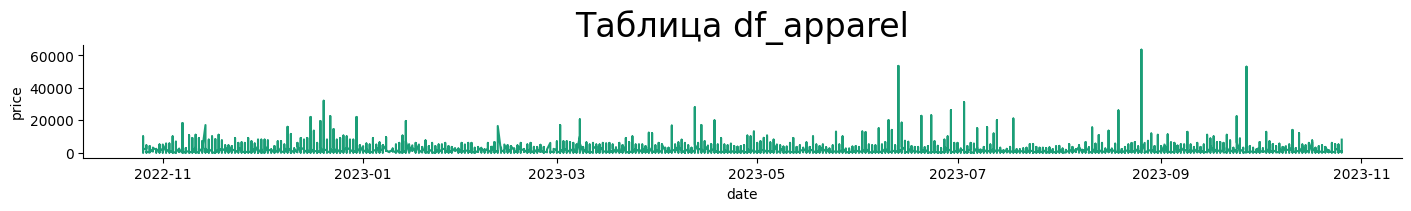

In [497]:
fig, ax = plt.subplots(figsize=(14, 2), layout='constrained')
df_sorted = df_apparel.sort_values('date', ascending=True)
_plot_series_price(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('price')
plt.title('Таблица df_apparel', size = 24)

Text(0.5, 1.0, 'Таблица df_gifts')

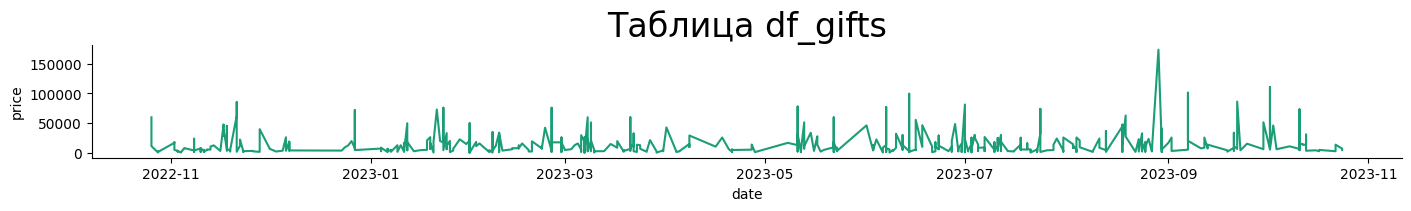

In [498]:
fig, ax = plt.subplots(figsize=(14, 2), layout='constrained')
df_sorted = df_gifts.sort_values('date', ascending=True)
_plot_series_price(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('price')
plt.title('Таблица df_gifts', size = 24)

Text(0.5, 1.0, 'Таблица df_marketplace')

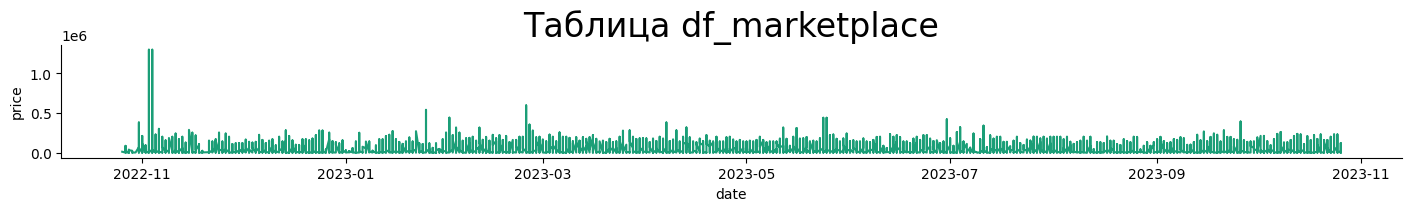

In [499]:
fig, ax = plt.subplots(figsize=(14, 2), layout='constrained')
df_sorted = df_marketplace.sort_values('date', ascending=True)
_plot_series_price(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('price')
plt.title('Таблица df_marketplace', size = 24)

На графиках видны небольшие скачки цен

df_apparel - одежда, перед новым годом, в июне, перед 1 сертября и в октябре.

df_gift - подарки, 1 сентября

df_marketplace - мультикатегорийный магазин, начало ноября.

Сложно сделать полезные однозначные выводы по ценам, проверим количество.

In [500]:
def _plot_series_quantity(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['quantity']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

Text(0.5, 1.0, 'Таблица df_apparel')

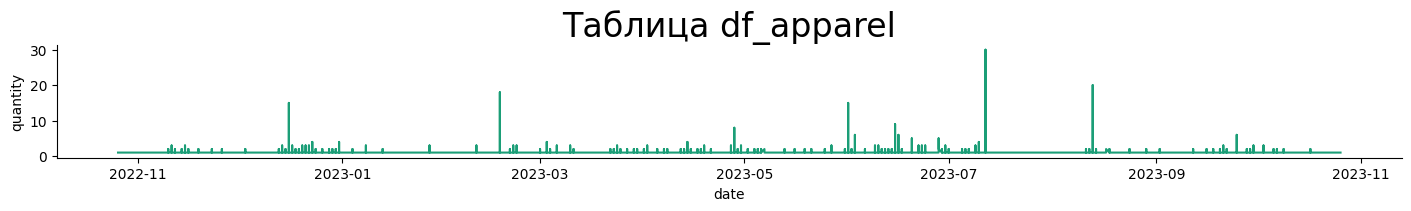

In [501]:
fig, ax = plt.subplots(figsize=(14, 2), layout='constrained')
df_sorted = df_apparel.sort_values('date', ascending=True)
_plot_series_quantity(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('quantity')
plt.title('Таблица df_apparel', size = 24)

Text(0.5, 1.0, 'Таблица df_gifts')

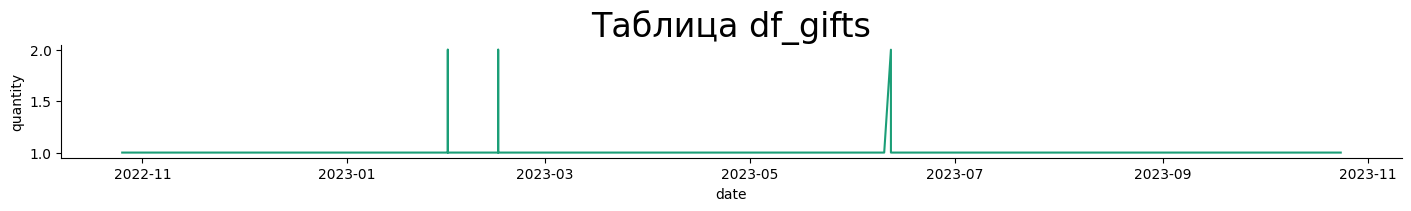

In [502]:
fig, ax = plt.subplots(figsize=(14, 2), layout='constrained')
df_sorted = df_gifts.sort_values('date', ascending=True)
_plot_series_quantity(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('quantity')
plt.title('Таблица df_gifts', size = 24)

Text(0.5, 1.0, 'Таблица df_marketplace')

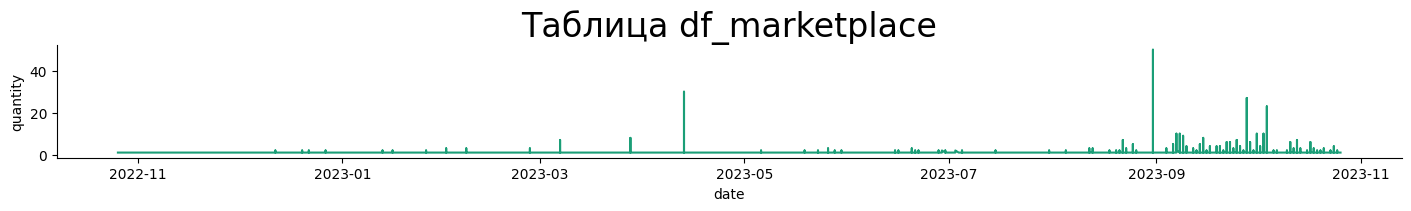

In [503]:
fig, ax = plt.subplots(figsize=(14, 2), layout='constrained')
df_sorted = df_marketplace.sort_values('date', ascending=True)
_plot_series_quantity(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('quantity')
plt.title('Таблица df_marketplace', size = 24)

Зависимость количества товаров от даты, также неоднозначна. На данном этапе сложно сделать полезный вывод.

## Подготовка данных к обучению

Для дальнейшей работы с данными объеденим 3 таблицы в 1 датасет и в таком виде оценим результат.

In [504]:
df = pd.concat([df_apparel, df_gifts, df_marketplace])

In [505]:
df.head(2)

,client_id,quantity,price,date
0,1515915625468068833,1,3499.00,2023-09-08
1,1515915625468068833,1,3499.00,2023-09-08


In [506]:
len(df_apparel)+len(df_gifts)+len(df_marketplace)-len(df)

0

###Генерация новых признаков

Генерация признаков нужна для обучения модели, по сути это и есть train

In [507]:
x = df

Для начала добавим признак - Общая цена - total_price.

In [508]:
x['total_price'] = x['quantity'] * x['price']

Для качественного обучения модели, добавим призники для каждого покупателя,наиболее распространенные базовые показатели.

- сумма (sum)  
- среднее значение (mean)  
- медианное значение (median)
- минимум (minimum)
- максимум (maximum)
- количество заказов (num_orders)
- общая цена (total_price)

In [509]:
agg_func = {
    'quantity': ['sum', 'mean', 'median', 'min', 'max'],
    'price': ['sum', 'mean', 'median', 'min', 'max'],
    'date': ['count']
}

In [510]:
x = pd.DataFrame(x.groupby(['client_id']).agg(agg_func))

Переименуем мульти названия столбцов для удобства при анализе

In [511]:
list_col = x.columns.to_list()

In [512]:
list_col_new = []
for i in list_col:
  list_col_new.append(i[0]+'_'+i[1])

In [513]:
x.columns = list_col_new

Добавим признаки количества покупок

- общее количество покупок за год (total_buy)
- средний период времени между покупками - (mean_buy_days)

In [514]:
x['total_buy'] = (pd.DataFrame(df.groupby('client_id')['date'].nunique())).values

In [515]:
x['mean_buy_days'] = 365 / x['total_buy']

In [516]:
x.head(2)

,quantity_sum,quantity_mean,quantity_median,quantity_min,quantity_max,price_sum,price_mean,price_median,price_min,price_max,date_count,total_buy,mean_buy_days
client_id,,,,,,,,,,,,,
1515915625440099873,2,1.00,1.00,1,1,33216.00,16608.00,16608.00,1218.00,31998.00,2,2,182.50
1515915625440939402,1,1.00,1.00,1,1,75998.00,75998.00,75998.00,75998.00,75998.00,1,1,365.00


На базе полученных признаков добавим еще:

- среднее количество единиц товара в месяц (mean_quantity_month)
- среднее количество заказов в месяц (mean_order_month)
- средний чек в месяц (mean_price_month)
- средний период времени между покупками (mean_buy_days)

In [517]:
x['mean_quantity_month'] = x['quantity_sum'] / 12

In [518]:
x['mean_order_month'] = x['date_count'] / 12

In [519]:
x['mean_price_month'] = x['price_sum'] / 12

In [520]:
x.head(2)

,quantity_sum,quantity_mean,quantity_median,quantity_min,quantity_max,price_sum,price_mean,price_median,price_min,price_max,date_count,total_buy,mean_buy_days,mean_quantity_month,mean_order_month,mean_price_month
client_id,,,,,,,,,,,,,,,,
1515915625440099873,2,1.00,1.00,1,1,33216.00,16608.00,16608.00,1218.00,31998.00,2,2,182.50,0.17,0.17,2768.00
1515915625440939402,1,1.00,1.00,1,1,75998.00,75998.00,75998.00,75998.00,75998.00,1,1,365.00,0.08,0.08,6333.17


Сгенерированы признаки для обучения модели, каждое наблюдение - это характеристика клиента. Получен обучающий датасет x.

In [521]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47004 entries, 1515915625440099873 to 1515915626013602677
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   quantity_sum         47004 non-null  int64  
 1   quantity_mean        47004 non-null  float64
 2   quantity_median      47004 non-null  float64
 3   quantity_min         47004 non-null  int64  
 4   quantity_max         47004 non-null  int64  
 5   price_sum            47004 non-null  float64
 6   price_mean           47004 non-null  float64
 7   price_median         47004 non-null  float64
 8   price_min            47004 non-null  float64
 9   price_max            47004 non-null  float64
 10  date_count           47004 non-null  int64  
 11  total_buy            47004 non-null  int64  
 12  mean_buy_days        47004 non-null  float64
 13  mean_quantity_month  47004 non-null  float64
 14  mean_order_month     47004 non-null  float64
 15  mean

#### Вывод:

1.	Объединены 3 таблицы в 1 датасет df .

2.	Сформирован датасет признаков x:  

  2.1	для признаков quantity, price, date  
- сумма (sum)  
- среднее значение (mean)  
- медианное значение (median)
- минимум (minimum)
- максимум (maximum)

  2.2	Дополнительные признаки:
- количество заказов (num_orders)
- общая цена (total_price)
- общее количество покупок за год (total_buy)
- средний период времени между покупками (mean_buy_days)
- среднее количество единиц товара в месяц (mean_quantity_month)
- среднее количество заказов в месяц (mean_order_month)
- средний чек в месяц (mean_price_month)
- средний период времени между покупками (mean_buy_days)  

###Генерация таргета

Цель - получение целевого признака 'y'

В качестве таргета сформируем бинарный категориальный признак y - клиенты, которые совершили покупки в течении последнего месяца периода.


1 - клиенты, совершили покупки   
0 - остальные клиенты

In [ ]:
df_y = df

In [ ]:
df_y[df_y['date'] >= df_y['date'].max() - timedelta(days = 30)])

8502

In [ ]:
df_y['y'] = (df_y['total_price']*0).astype(int)

In [ ]:
len(df_y[df_y['y'] == 1])

8502

In [ ]:
df_y['y'] = df_y['y'].apply(lambda x: 1 if df_y['date'] >= df_y['date'].max() - timedelta(days = 30) else 0)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
df_y['y'].apply(date_30())

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
df_y.loc[df_y['date'] >= (df_y['date'].max() - timedelta(days = 30)), 'y'] = 1

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (<ipython-input-415-6665c0b57d09>, line 1)

In [ ]:
len(df_y)

182097

In [ ]:
df_y = df.groupby('client_id').nunique()

In [ ]:
len(df_y)

47004

In [ ]:
df_y[df_y['y'] == 1]

,quantity,price,date,total_price,y
client_id,,,,,
1515915625440099873,1,2,2,2,1
1515915625440939402,1,1,1,1,1
1515915625440944408,1,3,3,3,1
1515915625440947454,1,4,2,4,1
1515915625440952940,1,1,1,1,1
...,...,...,...,...,...
1515915626005014483,1,1,1,1,1
1515915626010039507,1,2,1,2,1
1515915626011484905,1,5,1,5,1


#### Вывод:

1.	На основании анализа rfm получен  таргет y в виде 4х категорий покупателей для обучения модели:  
- premiere
- best
- potential
- so_so

  По результатам такой модели можно понять какие клиенты требую особого внимания.

2.	Дополнительно получен перечень клиентов, которые вероятнее всего совершат покупку в течении 30ти дней:

  2.1 таблица y_30 - Всего 36 клиентов которые совершают покупку не реже 1 раза в месяц  

  2.2 таблица rfm_30 - таблица с клиентами (3056 наблюдений), которые совершили покупки в течении последнего месяца периода.

Обучение основной модели будем проводить на основании признаков x по таргету у (мультикатегории).
Далее решение будет приниматься с учетом информации таблиц y_30 и rfm_30.





### Разделение данных на обучающую 75% и тестовую выборку 25%

 При кросс-валидации и подборе гиперпараметров через GridSearchCV/RandomizedSearchCV на каждой итерации происходит разбиение на трейн и тест. Предобработка признаков (масштабирование, кодирование, векторизация) каждый раз должна проводиться независимо, иначе происходит утечка данных.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25,shuffle=True, random_state=42
    )

In [ ]:
x_train.shape

(35253, 16)

In [ ]:
x_test.shape

(11751, 16)

In [ ]:
y_train.shape

(35253,)

In [ ]:
y_test.shape

(11751,)

### Обработка категориальных признаков

С целью исключения категориальных признаков в таргете для обучения модели преобразовать категориальные признаки в численные поможет техника LabelEncoder библиотеки sklearn. Этот класс преобразует n категорий в числа от 1 до n. Применим его к целевой переменной.

In [ ]:
labelencoder = LabelEncoder()
y_train = labelencoder.fit_transform(y_train.values)
y_test = labelencoder.fit_transform(y_test.values)

In [ ]:
y_train

array([3, 3, 0, ..., 1, 3, 1])

In [ ]:
y_test

array([0, 0, 3, ..., 0, 3, 1])

Приведение непрерывных значений признаков к единому масштабу. Для выборки train применяется метод fit и transform совместно - fit_transform, а для выборки test - transform

In [ ]:
x_train.head()

,quantity_sum,quantity_mean,quantity_median,quantity_min,quantity_max,price_sum,price_mean,price_median,price_min,price_max,date_count,total_buy,mean_buy_days,mean_quantity_month,mean_order_month,mean_price_month
client_id,,,,,,,,,,,,,,,,
1515915625566821487,1,1.00,1.00,1,1,3999.00,3999.00,3999.00,3999.00,3999.00,1,1,365.00,0.08,0.08,333.25
1515915625577221089,1,1.00,1.00,1,1,5999.00,5999.00,5999.00,5999.00,5999.00,1,1,365.00,0.08,0.08,499.92
1515915625559122412,3,1.00,1.00,1,1,347994.00,115998.00,115998.00,115998.00,115998.00,3,1,365.00,0.25,0.25,28999.50
1515915625485721611,14,1.00,1.00,1,1,24810.00,1772.14,1949.00,599.00,2499.00,14,1,365.00,1.17,1.17,2067.50
1515915625947193107,3,1.00,1.00,1,1,1197.00,399.00,399.00,199.00,599.00,3,1,365.00,0.25,0.25,99.75


In [ ]:
x_test.head()

,quantity_sum,quantity_mean,quantity_median,quantity_min,quantity_max,price_sum,price_mean,price_median,price_min,price_max,date_count,total_buy,mean_buy_days,mean_quantity_month,mean_order_month,mean_price_month
client_id,,,,,,,,,,,,,,,,
1515915625518117010,6,1.00,1.00,1,1,2826.00,471.00,54.00,2.00,1796.00,6,1,365.00,0.50,0.50,235.50
1515915625551836337,3,1.00,1.00,1,1,42794.00,14264.67,7598.00,1198.00,33998.00,3,2,182.50,0.25,0.25,3566.17
1515915625518107116,1,1.00,1.00,1,1,2.00,2.00,2.00,2.00,2.00,1,1,365.00,0.08,0.08,0.17
1515915625518777669,1,1.00,1.00,1,1,2036.00,2036.00,2036.00,2036.00,2036.00,1,1,365.00,0.08,0.08,169.67
1515915625586004794,8,1.00,1.00,1,1,9150.00,1143.75,1085.50,10.00,2461.00,8,1,365.00,0.67,0.67,762.50


In [ ]:
list_x = list(x_train.columns)

In [ ]:
numeric = list_x

In [ ]:
scaler = StandardScaler()

In [ ]:
x_train[numeric] = scaler.fit_transform(x_train[numeric])

In [ ]:
x_test[numeric] = scaler.transform(x_test[numeric])

In [ ]:
x_train.head()

,quantity_sum,quantity_mean,quantity_median,quantity_min,quantity_max,price_sum,price_mean,price_median,price_min,price_max,date_count,total_buy,mean_buy_days,mean_quantity_month,mean_order_month,mean_price_month
client_id,,,,,,,,,,,,,,,,
1515915625566821487,-0.45,-0.05,-0.04,-0.03,-0.04,-0.20,-0.31,-0.29,-0.20,-0.37,-0.47,-0.24,0.39,-0.45,-0.47,-0.20
1515915625577221089,-0.45,-0.05,-0.04,-0.03,-0.04,-0.18,-0.24,-0.22,-0.12,-0.31,-0.47,-0.24,0.39,-0.45,-0.47,-0.18
1515915625559122412,-0.14,-0.05,-0.04,-0.03,-0.04,2.22,3.77,3.76,4.20,2.81,-0.14,-0.24,0.39,-0.14,-0.14,2.22
1515915625485721611,1.59,-0.05,-0.04,-0.03,-0.04,-0.05,-0.39,-0.37,-0.33,-0.41,1.66,-0.24,0.39,1.59,1.66,-0.05
1515915625947193107,-0.14,-0.05,-0.04,-0.03,-0.04,-0.22,-0.44,-0.42,-0.35,-0.47,-0.14,-0.24,0.39,-0.14,-0.14,-0.22


In [ ]:
x_test.head()

,quantity_sum,quantity_mean,quantity_median,quantity_min,quantity_max,price_sum,price_mean,price_median,price_min,price_max,date_count,total_buy,mean_buy_days,mean_quantity_month,mean_order_month,mean_price_month
client_id,,,,,,,,,,,,,,,,
1515915625518117010,0.33,-0.05,-0.04,-0.03,-0.04,-0.21,-0.44,-0.44,-0.36,-0.43,0.35,-0.24,0.39,0.33,0.35,-0.21
1515915625551836337,-0.14,-0.05,-0.04,-0.03,-0.04,0.08,0.06,-0.16,-0.31,0.48,-0.14,0.84,-2.14,-0.14,-0.14,0.08
1515915625518107116,-0.45,-0.05,-0.04,-0.03,-0.04,-0.23,-0.46,-0.44,-0.36,-0.49,-0.47,-0.24,0.39,-0.45,-0.47,-0.23
1515915625518777669,-0.45,-0.05,-0.04,-0.03,-0.04,-0.21,-0.38,-0.37,-0.28,-0.43,-0.47,-0.24,0.39,-0.45,-0.47,-0.21
1515915625586004794,0.64,-0.05,-0.04,-0.03,-0.04,-0.16,-0.42,-0.40,-0.36,-0.42,0.68,-0.24,0.39,0.64,0.68,-0.16


#### Вывод:

1.	Датасет разделен на обучающую 75% и тестовую выборку 25%
2.	Категориальные признаки в таргете преобразованы в численные техникой LabelEncoder библиотеки sklearn.
3.	Проведено масштабирование признаков. Для выборки train применен метод fit и transform совместно - fit_transform, а для выборки test – transform.


# Обучение модели

В таргете имеем дисбалланс классов - устраняем.

In [ ]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

Обучать будем модель CatBoostClassifier

In [ ]:
%%time

model = CatBoostClassifier(
        random_state=42,
        early_stopping_rounds=100,
        #learning_rate=0.01,
        leaf_estimation_method='Gradient',
        iterations=1000,
        subsample=0.02,
        #max_depth=4,
        verbose=100,
        #l2_leaf_reg = 7,
        bootstrap_type="Bernoulli",
        class_weights=class_weights,
        loss_function='MultiClass',
        eval_metric='TotalF1'
        )

model.fit(x_train, y_train)
pred = model.predict(x_test)

0:	learn: 1.3556083	total: 56.5ms	remaining: 56.4s
100:	learn: 0.6507665	total: 6.85s	remaining: 1m
200:	learn: 0.6085929	total: 12.3s	remaining: 48.9s
300:	learn: 0.5884000	total: 19s	remaining: 44.2s
400:	learn: 0.5731976	total: 24.4s	remaining: 36.5s
500:	learn: 0.5617338	total: 31.2s	remaining: 31.1s
600:	learn: 0.5526687	total: 36.6s	remaining: 24.3s
700:	learn: 0.5461134	total: 43.5s	remaining: 18.5s
800:	learn: 0.5407762	total: 49s	remaining: 12.2s
900:	learn: 0.5360704	total: 55.8s	remaining: 6.13s
999:	learn: 0.5317490	total: 1m 1s	remaining: 0us
CPU times: user 1min 44s, sys: 2.43 s, total: 1min 47s
Wall time: 1min 1s


In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.48      0.72      0.58      1839
           1       0.76      0.46      0.58      5854
           2       0.42      0.97      0.58       284
           3       0.67      0.84      0.74      3774

    accuracy                           0.64     11751
   macro avg       0.58      0.75      0.62     11751
weighted avg       0.68      0.64      0.63     11751



**************

# Вывод

С целью создания решения для предсказания, совершит ли покупатель повторную покупку в течение ближайших 30 дней по информации трех интернет-магазинов: мультикатегорийный магазин с посещаемостью более 8 млн сессий в месяц, магазин одежды, маленький магазин подарков проведен исследовательский анализ данных, предобработка и генерация необходимых признаков.

Данные использованы для обучения модели CatBoostClassifier.

В ходе проверки модели получены значения удовлетворительного уровня recall - 0.75, при этом значение precision 0.58.

Модель предсказывает категорию покупателя premiere, best, potential и so_so.
Далее для получения результата КАКОЙ ПОКУПАТЕЛЬ КУПИТ В ТЕЧЕНИИ 30 ДНЕЙ следует воспользоваться алгоритмом расчета:

1. таблица y_30 - клиенты, которые совершают покупку не реже 1 раза в месяц
2. таблица таблица y_30 - клиенты, которые совершили покупки в течении последнего месяца заданного периода
